# 这个月的主要任务在了解基本工具
## 1.爬虫爬取数据 
### 1.1 requests
### 1.2 Beautifulsoup

In [1]:
#爬数据并没有涉及有过于变态的反爬虫机制，主要就是
#1.requests
#2.Beautiful soup
import requests
from bs4 import BeautifulSoup
url = "http://lol.uuu9.com/201506/493276.shtml"
res = requests.get(url)
res.encoding='gbk'
soup = BeautifulSoup(res.text)
link = soup.find_all(class_ = "textdetail")
#for i in link:
#    print(i.text)

## 2.mango存数据
### 2.1 先连接mongoDB，再选择数据库以及相应的集合
### 2.2 空数据库只有插入数据才会显示出来
### 2.3 数据库的读取只涉及了全部读取 table.find()

In [2]:
from pymongo import MongoClient
import pandas as pd
client = MongoClient()
# client = MongoClient('xxx.xxx.xxx.xxx')
db = client['douyu']  # 获取数据库(database)
#db = Client.database_name
table = db['网游竞技']  # 获取Collection
#coll = db.collection_name

## 3.pandas读数据
### 3.1 首先构造DataFrame
### 3.2 注意在选择多个列的时候要用双重嵌套 [['a','b','c']] 
### 3.3 注意在选择某一特定元素的时候可以用 loc方法
### 3.4 删除某一行或某一列用del

In [3]:
# 读取数据
data = pd.DataFrame(list(table.find()))

# 选择需要显示的字段
data = data[['name', 'content','level']]

# 打印输出
content = data['content']

#将label添加到数据中：
#for index, label in enumerate(kmeans.labels_, 1):
#data.loc[index-1]['label'] = label

In [ ]:
del data['cut_comment_1']
del data['cut_comment_2']

## 4.jieba分词
### 4.1 首先需要使用停用词表，即去除特定的词，由于本次使用的是有关英雄联盟的数据，所以要把相应的游戏无意义词汇删除掉，所以词库的收集十分重要，可以去搜狗的词库网站找一些，然后再去重
### 4.2 分词时顺带标注词性，这样做的意义是去除停用词表中没有的无意义词汇，如介词连词等
### 4.3Jieba分词词性标注以及词性说明本文链接：https://blog.csdn.net/enter89/article/details/80619805

In [4]:
stopwords = [line.strip() for line in open("stopwords.txt",encoding="utf-8").readlines()]
# 对句子进行jieba分词
import jieba
import jieba.analyse
import jieba.posseg
 
def dosegment_all(sentence):
    sentence_seged = jieba.posseg.cut(sentence.strip())
    outstr = []
    for word, flag in sentence_seged:
        if word not in stopwords and (flag == "a" or flag == "v" or flag == "n"):
            outstr.append("{}:{}".format(word,flag))
    return outstr

def dosegment_all_1(sentence):
    sentence_seged = jieba.posseg.cut(sentence.strip())
    outstr = []
    for word, flag in sentence_seged:
        if word not in stopwords and (flag == "a" or flag == "v" or flag == "n"):
            outstr.append(word)
    return " ".join(outstr) 

def dosegment_all_2(sentence):
    sentence_seged = jieba.posseg.cut(sentence.strip())
    outstr = []
    for word, flag in sentence_seged:
        if word not in stopwords and (flag == "a" or flag == "v" or flag == "n"):
            outstr.append(word)
    return outstr

data['cut_comment_1'] = data.content.apply(dosegment_all)
data['cut_comment_2'] = data.content.apply(dosegment_all_1)
data['cut_comment_3'] = data.content.apply(dosegment_all_2)

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\shinelon\AppData\Local\Temp\jieba.cache
Loading model cost 0.795 seconds.
Prefix dict has been built succesfully.


#### Apply 函数的用法：https://www.jb51.net/article/138021.htm Join函数的用法 https://www.runoob.com/python/att-string-join.html

In [5]:
data.head(10)

,name,content,level,cut_comment_1,cut_comment_2,cut_comment_3
0,大鹌鹑是个大娘们：,枪斗打不赢帝骑,11,"[枪:n, 斗:v, 赢:v, 帝骑:n]",枪 斗 赢 帝骑,"[枪, 斗, 赢, 帝骑]"
1,大黄口小兵仔：,没得打，是因为没有质量，根本没有解决问题,20,"[没得:v, 没有:v, 质量:n, 根本:a, 没有:v, 解决问题:n]",没得 没有 质量 根本 没有 解决问题,"[没得, 没有, 质量, 根本, 没有, 解决问题]"
2,超极必杀特别超人：,现在升8升9也只有乌鸦和潘森的概率变高,4,"[升:v, 升:v, 概率:n, 变高:v]",升 升 概率 变高,"[升, 升, 概率, 变高]"
3,颠倒众水：,卖小炮呀,2,"[卖:v, 炮:n]",卖 炮,"[卖, 炮]"
4,消失的青菜：,下小炮，上布隆,6,[],,[]
5,不懂感恩：,德莱文没机会,10,"[没:v, 机会:n]",没 机会,"[没, 机会]"
6,大鹌鹑是个大娘们：,还有卡莎-_-,11,[],,[]
7,大鹌鹑是个大娘们：,卡莎五星,11,[],,[]
8,RZ的托马斯回旋：,先把船长下去,11,[],,[]
9,RZ的托马斯回旋：,上德莱文,11,[],,[]


## 5.词云


In [6]:
import numpy as np # numpy数据处理库
import wordcloud  # 词云展示库
from PIL import Image # 图像处理库
import matplotlib.pyplot as plt # 图像展示库

corpus = []
for i in data['cut_comment_3']:
    corpus.append(i)
word_lst = []
word_count={}
for count in corpus:
    for word in count:
        if word not in stopwords:
            if len(word) == 1:
                continue
            else:
                word_lst.append(word)
word_dict = {}
for item in word_lst:
    if item not in word_dict:
        word_dict[item] = 1
    else:
        word_dict[item] += 1
#创建词云
img = Image.open('1.jpg') #打开图片
img_array = np.array(img) #将图片装换为数组
#mask = np.array(Image.open('wordcloud.jpg')) # 定义词频背景
wc = wordcloud.WordCloud(
    font_path='C:/Windows/Fonts/STHUPO.TTF', # 设置字体格式
    #font_path='/usr/share/fonts/truetype/arphic/ukai.ttc', #  设置字体格式
    background_color='white',
    mask=img_array,
    max_words=100, # 最多显示词数
    max_font_size=200, # 字体最大值
    width=100, height=86, margin=2
)
wc.generate_from_frequencies(word_dict) # 从字典生成词云
image_color = wordcloud.ImageColorGenerator(img_array) # 从背景图建立颜色方案
wc.recolor(color_func=image_color) # 将词云颜色设置为背景图方案

## 6.plt画图


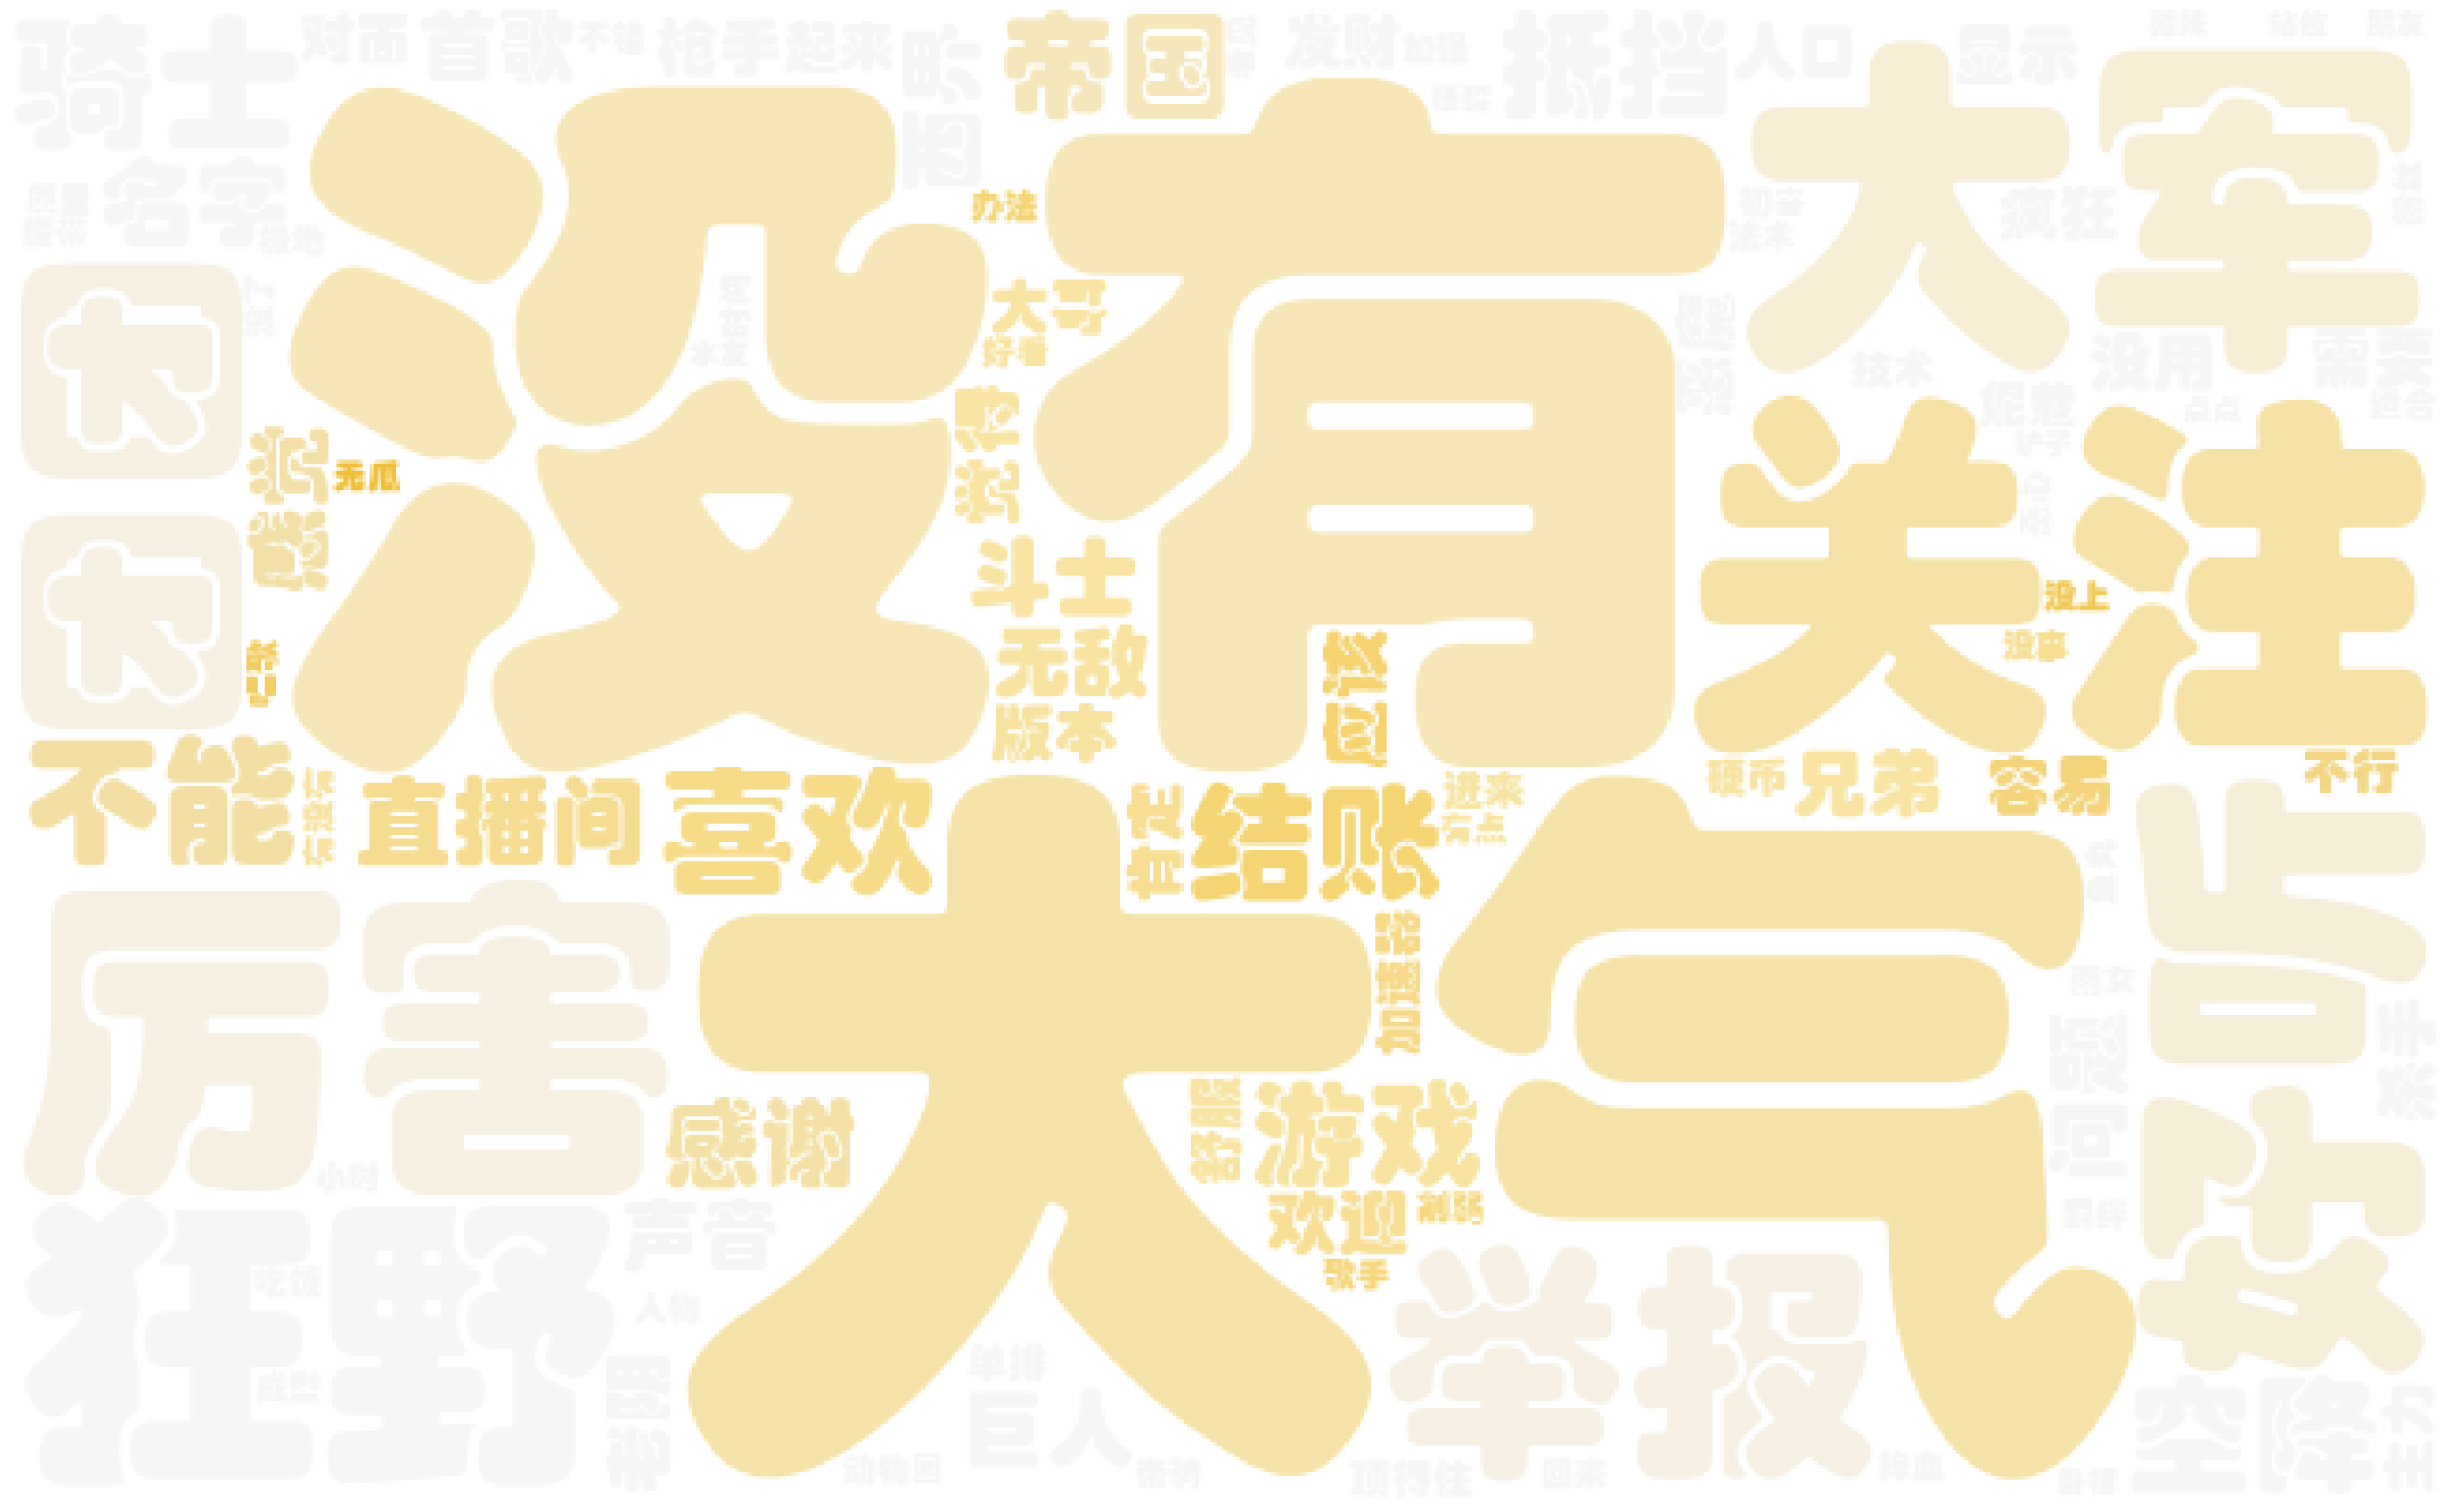

In [7]:
plt.figure(figsize=(50,50))
#plt.imshow(wc) # 显示词云
plt.imshow(wc.recolor(color_func=image_color))
#plt.imshow(wc.recolor(color_func=random_color_func, random_state=3),interpolation="bilinear")
plt.axis('off') # 关闭坐标轴
plt.savefig(r"F:\大学\论文复现\test.png")
plt.show() # 显示图像

## 7.文本聚类
### 7.1 python scikit-learn计算tf-idf词语权重https://blog.csdn.net/liuxuejiang158/article/details/31360765
### 7.2https://www.jianshu.com/p/622222b96f76
### 7.3 制作词云的时候需要用逗号隔开分词后的元素，而聚类则是需要用空格，谨记

In [8]:
corpus = []
for i in data['cut_comment_2']:
    if i != None:
        corpus.append(i)
word_lst = []
word_count={}
#for count in corpus:
#    print(count)

inertia: 452.55879080891293


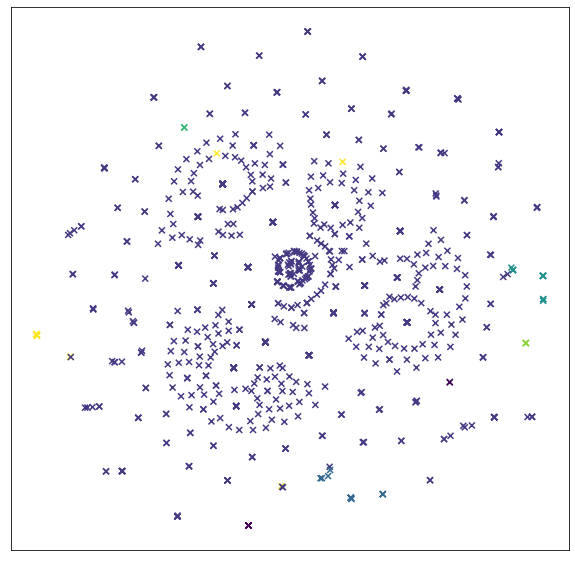

In [9]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
#from data_utils import *
import jieba
import matplotlib.pyplot as plt
'''
    2、计算tf-idf设为权重
'''

vectorizer = CountVectorizer()
transformer = TfidfTransformer()
tfidf = transformer.fit_transform(vectorizer.fit_transform(corpus))

''' 
    3、获取词袋模型中的所有词语特征
    如果特征数量非常多的情况下可以按照权重降维
'''

word = vectorizer.get_feature_names()
#print("word feature length: {}".format(len(word)))

''' 
    4、导出权重，到这边就实现了将文字向量化的过程，矩阵中的每一行就是一个文档的向量表示
'''
tfidf_weight = tfidf.toarray()
'''
    5、对向量进行聚类
'''

# 指定分成7个类
kmeans = KMeans(n_clusters=7)
kmeans.fit(tfidf_weight)

# 打印出各个族的中心点
#print(kmeans.cluster_centers_)
#for index, label in enumerate(kmeans.labels_, 1):
#    print("index: {}, label: {}".format(index, label))

# 样本距其最近的聚类中心的平方距离之和，用来评判分类的准确度，值越小越好
# k-means的超参数n_clusters可以通过该值来评估
print("inertia: {}".format(kmeans.inertia_))

data['label'] = None

'''
    6、可视化
'''

# 使用T-SNE算法，对权重进行降维，准确度比PCA算法高，但是耗时长
tsne = TSNE(n_components=2)
decomposition_data = tsne.fit_transform(tfidf_weight)

x = []
y = []

for i in decomposition_data:
    x.append(i[0])
    y.append(i[1])

fig = plt.figure(figsize=(10, 10))
ax = plt.axes()
plt.scatter(x, y, c=kmeans.labels_, marker="x")
plt.xticks(())
plt.yticks(())
# plt.show()
plt.savefig('./sample.png', aspect=1)